In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
from sklearn.metrics import r2_score

**Задание:**

Для приведенного выше датасета, построить модель линейной регрессии для
оценивания стоимости аренды недвижимости. Для решения задачи предлагается
использовать следующие подходы:
1. Получить решение задачи в замкнутом виде с помощью псевдообратной
матрицы. Рассмотреть случаи без регуляризации и с 𝐿 регуляризацией.
2
2. Получить решение задачи методом градиентного спуска. Получить формулу
для градиента, используя матрицу признаков. Сравнить полученные решение с
п.1.

**описание датасета:**

BHK: Number of Bedrooms, Hall, Kitchen.

Rent: Rent of the Houses/Apartments/Flats.

Size: Size of the Houses/Apartments/Flats in Square Feet.

Floor: Houses/Apartments/Flats situated in which Floor and Total Number of Floors (Example: Ground out of 2, 3 out of 5, etc.)

Area Type: Size of the Houses/Apartments/Flats calculated on either Super Area or Carpet Area or Build Area.

Area Locality: Locality of the Houses/Apartments/Flats.

City: City where the Houses/Apartments/Flats are Located.

Furnishing Status: Furnishing Status of the Houses/Apartments/Flats, either it is Furnished or Semi-Furnished or Unfurnished.

Tenant Preferred: Type of Tenant Preferred by the Owner or Agent.

Bathroom: Number of Bathrooms.

Point of Contact: Whom should you contact for more information regarding the Houses/Apartments/Flats.

**Целевая метка - Rent**

**считываем датасет**

In [2]:
df = pd.read_csv('House_Rent_Dataset.csv')

In [3]:
print(f'размер датасета: {df.shape}')
df.head()

размер датасета: (4746, 12)


,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4746 entries, 0 to 4745
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Posted On          4746 non-null   object
 1   BHK                4746 non-null   int64 
 2   Rent               4746 non-null   int64 
 3   Size               4746 non-null   int64 
 4   Floor              4746 non-null   object
 5   Area Type          4746 non-null   object
 6   Area Locality      4746 non-null   object
 7   City               4746 non-null   object
 8   Furnishing Status  4746 non-null   object
 9   Tenant Preferred   4746 non-null   object
 10  Bathroom           4746 non-null   int64 
 11  Point of Contact   4746 non-null   object
dtypes: int64(4), object(8)
memory usage: 445.1+ KB


**более детально рассмотрим признаки**

In [15]:
display(df.sample(10)['Floor'])
print(df['Floor'].nunique())

2978      1 out of 1
701     14 out of 18
4134      5 out of 6
75        1 out of 4
2180      4 out of 5
1036      1 out of 7
3306     9 out of 18
1004    11 out of 21
4266      1 out of 6
1569      1 out of 4
Name: Floor, dtype: object

480


In [26]:
display(df.sample(10)['Area Locality'])

print(df['Area Locality'].nunique())

3280                                           Medavakkam
4268                     Upparpally, Hyderabad Expressway
2471                                        Malviya Nagar
2237                    Laxminarayana Layout, Munnekollal
3715                       Teachers's Colony-Lakshmipuram
3191                                   Tiruvenkadam Nagar
2913                                               Burari
27                             Kodalia, Hooghly-Chinsurah
4480                                   Vijaya Puri Colony
4129    Hormany nest Apartments gandipet Apartmentge h...
Name: Area Locality, dtype: object

2235


In [28]:
display(df.sample(10)['Posted On'])

print(df['Posted On'].nunique())

3843    2022-05-06
1753    2022-07-02
3598    2022-06-13
1833    2022-06-04
3511    2022-05-06
1926    2022-07-07
2125    2022-05-05
4683    2022-06-02
3327    2022-05-25
2989    2022-05-20
Name: Posted On, dtype: object

81


**Для удобства уберём признаки Floor, Area Locality, Posted On**

Floor - в теории этот признак можно распарсить и получить полезную информацию

Area Locality - ограничимся признаком City

Posted On - кажется, что этот признак бесполезен

In [10]:
features_to_drop = ['Floor', 'Area Locality', 'Posted On']

**подготовка данных**

In [11]:
cat_features = []
num_features = []

for column in df.columns:
    nunique_vals = df[column].nunique()
    print(f"{column}, nunique vals: {nunique_vals}")
    if column not in features_to_drop:
        if nunique_vals <= 6:
            cat_features.append(column)
        else:
            num_features.append(column)

print('\ncat features:', cat_features)
print('num features:', num_features)

Posted On, nunique vals: 81
BHK, nunique vals: 6
Rent, nunique vals: 243
Size, nunique vals: 615
Floor, nunique vals: 480
Area Type, nunique vals: 3
Area Locality, nunique vals: 2235
City, nunique vals: 6
Furnishing Status, nunique vals: 3
Tenant Preferred, nunique vals: 3
Bathroom, nunique vals: 8
Point of Contact, nunique vals: 3

cat features: ['BHK', 'Area Type', 'City', 'Furnishing Status', 'Tenant Preferred', 'Point of Contact']
num features: ['Rent', 'Size', 'Bathroom']


In [12]:
df[num_features].head()

,Rent,Size,Bathroom
0,10000,1100,2
1,20000,800,1
2,17000,1000,1
3,10000,800,1
4,7500,850,1


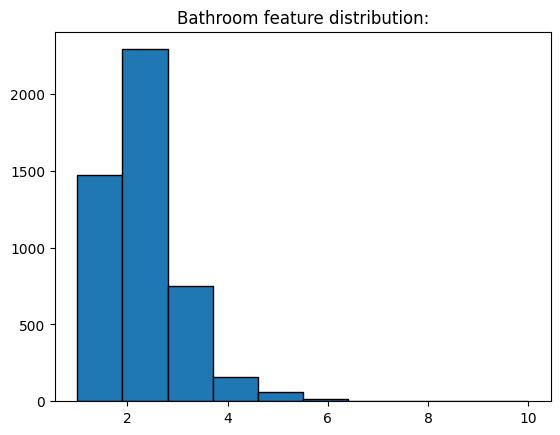

In [13]:
plt.title('Bathroom feature distribution:')
plt.hist(df['Bathroom'], ec='k')
plt.show()

In [14]:
df.drop(features_to_drop, axis=1, inplace=True)

In [15]:
df[num_features].describe()

,Rent,Size,Bathroom
count,4.746000e+03,4746.000000,4746.000000
mean,3.499345e+04,967.490729,1.965866
std,7.810641e+04,634.202328,0.884532
min,1.200000e+03,10.000000,1.000000
25%,1.000000e+04,550.000000,1.000000
50%,1.600000e+04,850.000000,2.000000
75%,3.300000e+04,1200.000000,2.000000
max,3.500000e+06,8000.000000,10.000000


**кодируем категориальные признаки с помощью One Hot Encoding**

In [16]:
df_ohe = pd.get_dummies(df, columns=cat_features).astype(int)
df_ohe

,Rent,Size,Bathroom,BHK_1,BHK_2,BHK_3,BHK_4,BHK_5,BHK_6,Area Type_Built Area,...,City_Mumbai,Furnishing Status_Furnished,Furnishing Status_Semi-Furnished,Furnishing Status_Unfurnished,Tenant Preferred_Bachelors,Tenant Preferred_Bachelors/Family,Tenant Preferred_Family,Point of Contact_Contact Agent,Point of Contact_Contact Builder,Point of Contact_Contact Owner
0,10000,1100,2,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
1,20000,800,1,0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
2,17000,1000,1,0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
3,10000,800,1,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
4,7500,850,1,0,1,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4741,15000,1000,2,0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
4742,29000,2000,3,0,0,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
4743,35000,1750,3,0,0,1,0,0,0,0,...,0,0,1,0,0,1,0,1,0,0
4744,45000,1500,2,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,1,0,0


**рассмотрим корреляцию вещественных признаков**

численные признаки хорошо коррелируют с таргетом, вероятно они будут важны при построении линейной модели

<Axes: >

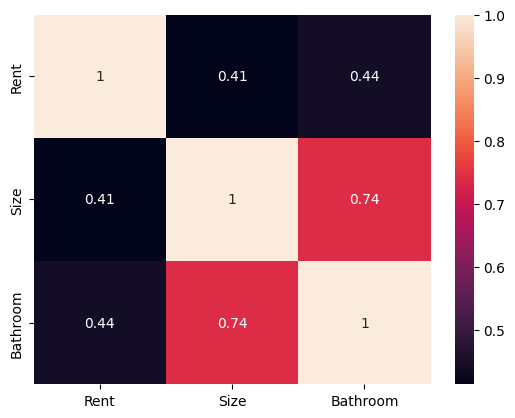

In [ ]:
sns.heatmap(df_ohe[num_features].corr(), annot=True)

**обучение модели**

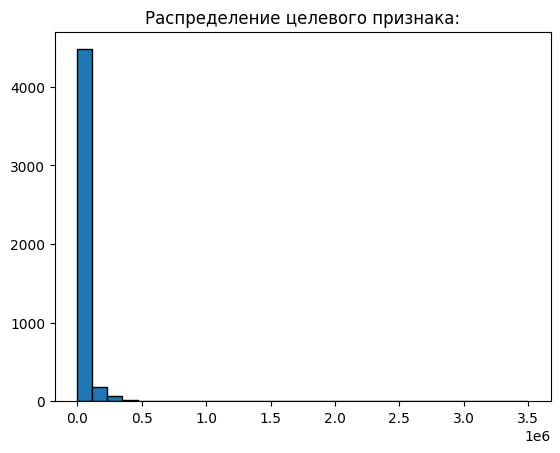

In [15]:
plt.title('Распределение целевого признака:')
plt.hist(df['Rent'], bins=30, ec='k')
plt.show()

разбиваем данные да обучение и тест

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df_ohe.loc[:, df_ohe.columns != 'Rent'], df_ohe['Rent'], 
                                                    test_size=0.2, random_state=42, shuffle=True)

In [18]:
print(X_train.shape, X_test.shape)

(3796, 26) (950, 26)


нормируем числовые признаки

In [38]:
scale_features = ['Size', 'Bathroom']
scaler = StandardScaler()

X_train[scale_features] = scaler.fit_transform(X_train[scale_features])
X_test[scale_features] = scaler.transform(X_test[scale_features])

учим модель и смотрим метрики

In [39]:
def check_metrics(y_test, y_pred):
    metrics = [mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score]

    for metric in metrics:
        if metric.__name__ == 'mean_squared_error':
            print(f"root_{metric.__name__}, {np.sqrt(metric(y_test, y_pred))}")
        print(f"{metric.__name__}, {metric(y_test, y_pred)}")

**проверка качества для реализованной модели**

In [40]:
model = LinearRegression()
model.fit(X_train, y_train)

check_metrics(y_test, model.predict(X_test))

mean_absolute_error, 19485.345263157895
root_mean_squared_error, 42057.36934223863
mean_squared_error, 1768822315.9894736
mean_absolute_percentage_error, 0.9035464684611079
r2_score, 0.5561723771907251


# реализуем руками то, что было использовано выше

модель линейной регрессии для предсказания использует веса, вычислямые следующим образом:

$$w = (X^{T}X)^{-1} X^{T}y$$

в случае добавления регуляризации:

$$w = (X^{T}X + \alpha I)^{-1} X^{T}y$$

In [169]:
def logistic_regression_solution(X, Y, alpha=None):
    #добавляем единичную матрицу для вычисления bias'а
    ones_column = np.ones((len(X), 1))
    X = np.hstack((X, ones_column))

    X_inv = np.dot(np.linalg.inv(np.dot(X.T, X)), X.T)

    if alpha is not None:
        X_inv = np.dot(np.linalg.inv(np.dot(X.T, X) + alpha * np.identity(len(X[0]))), X.T)
    
    weights = np.dot(X_inv, Y).reshape(-1)

    w = weights[:-1]
    bias = weights[-1]

    return w, bias

**аналитическое решение линейной регрессии**

In [43]:
w, bias = logistic_regression_solution(X_train.values, y_train.values)

print(w.shape, bias)

(26,) 740671.3986816406


без регуляризации получаем просто гигантские значения метрик, что очень плохо

In [44]:
check_metrics(y_test.values, np.dot(X_test, w) + bias)

mean_absolute_error, 3637926.7327174135
root_mean_squared_error, 4536275.063660111
mean_squared_error, 20577791453184.543
mean_absolute_percentage_error, 303.10400013744334
r2_score, -5162.318090671501


с регуляризацией результат сходится с реализованным методом в sklearn (по умолчанию там как раз стоит l2 penalty = 1)

значит мы правильно реализовали аналитическое решение

In [170]:
w, bias = logistic_regression_solution(X_train.values, y_train.values, alpha=10)

y_pred = np.dot(X_test, w) + bias
check_metrics(y_test.values, y_pred)

mean_absolute_error, 19666.486874333666
root_mean_squared_error, 42060.87539993346
mean_squared_error, 1769117239.4087274
mean_absolute_percentage_error, 0.9166613565386771
r2_score, 0.5560983758855093


в результате использования l2 регуляризации удалось существенно улучшить качество модели, l2 регуляризация позволяет стабилизировать рассчёт псевдообратной матрицы.

Также получается, что l2 регуляризация помогает избавиться от переобучения в данном примере.

Получившиеся значения метрик:

1) MAE: 19481
2) RMSE: 42056
3) MAPE: 0.90
4) R2: 0.55

**важность признаков**

наиболее важные признаки в линейной регрессии будут иметь наибольшие по модулю веса

изобразим на графике наиболее важные признаки:

In [172]:
features_dict = dict(zip(
    list(X_train.columns), list(w)
))

features_dict = dict(sorted(features_dict.items(), key=lambda x: x[1], reverse=False))

Самые важные признаки, которые сильнее всего влияеют на стоимость аренды - это площадь жилья, город жилья, и количество комнат (и ванных тоже).

Это вполне логично и согласуется со здравым смыслом.

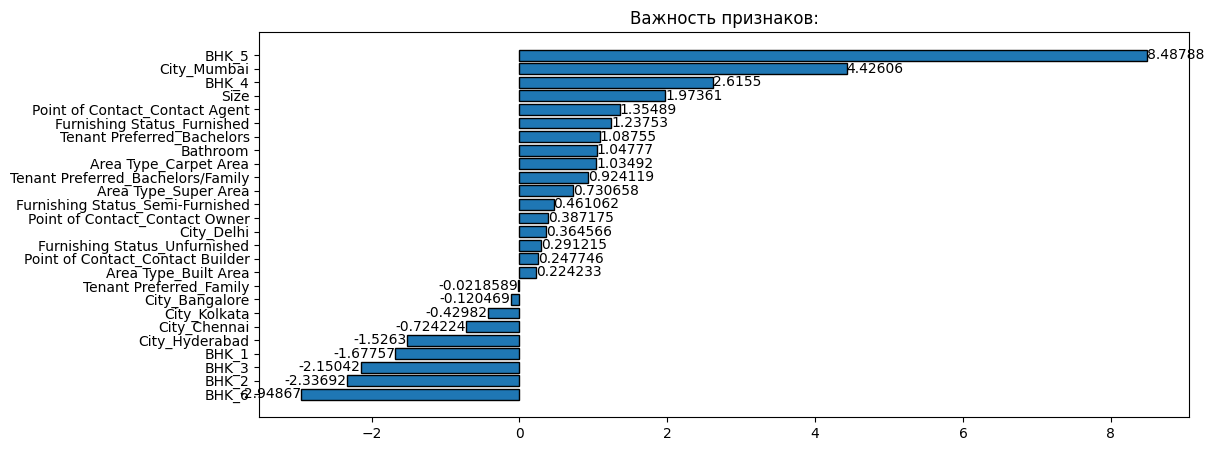

In [181]:
plt.figure(figsize=(12, 5))
plt.title('Важность признаков:')
bars = plt.barh(list(features_dict.keys()), 
                np.array(list(features_dict.values()))/1e4, ec='k')
plt.bar_label(bars)
plt.show()

**в задании было предложено рассмотреть способы отбора с наиболее важных признаков - это признаки с наибольшими весами**

**однако также можно использовать l1 регуляризацию, которая занулит шумовые признаки и оставит релевантные**

# метод градиентного спуска
$$h_{\theta}(x) = \sum_{j = 0}^{n}\theta_{j}x_{j}$$

$$J_{train}(\theta) = \frac{1}{m} \sum_{i=1}^{m}(h_{\theta}(x^{(i)}) - y^{(i)})^2$$

repeat for each j = 0, ..., n:
$$\theta_{j} = \theta_{j} - \alpha \frac{2}{m} \sum_{i=1}^{m}(h_{\theta}(x^{(i)}) - y^{(i)})x_{j}^{(i)}$$

In [156]:
def weights_distance(w_0, w_1):
   return np.sqrt(np.sum((w_0 - w_1)**2))

def gradient_desc(X, Y, w_start=None, verbose=1000,
                  learning_rate=1e-2, epsilon=1e-5, max_iteration=5e4, alpha=None):
  assert isinstance(X, np.ndarray)
  assert isinstance(Y, np.ndarray)
  
  ones_column = np.ones((len(X), 1))
  X = np.hstack((X, ones_column))

  if w_start is None:
      w_start = np.zeros(X.shape[1]).reshape(-1, 1)
  
  w = w_start
  w_dist = np.inf
  step = 0

  #повторяем шаг градиентного спуска до выполнения условий остановки
  while (w_dist > epsilon) and (step < max_iteration):
    #градиент в матричной форме
    gradient_step = learning_rate * (2/len(X)) * np.dot(X.T, (np.dot(X, w).squeeze() - Y))
    w_next = w - gradient_step.reshape(-1, 1)
    # l2 регуляризация
    if alpha is not None:
      w_next[:-1] = w_next[:-1] - learning_rate * (2/len(X)) * alpha * w_next[:-1]
    
    w_dist = weights_distance(w, w_next)
    step += 1
    w = w_next
    if step % verbose == 0:
       print(f'step: {step}, w distance: {w_dist}')

  bias = w[-1].reshape(-1)
  weights = w[:-1].reshape(-1)
  return weights, bias

**градиентный спуск без регуляризации**

In [159]:
weights, bias = gradient_desc(X_train.values, y_train.values, 
                              learning_rate=0.1, verbose=10000, max_iteration=1e5)

step: 10000, w distance: 1.0360811089673245
step: 20000, w distance: 0.43956582938773214
step: 30000, w distance: 0.206983674801336
step: 40000, w distance: 0.09859265688537149
step: 50000, w distance: 0.04708465918596943
step: 60000, w distance: 0.022499068719397348
step: 70000, w distance: 0.010752390707786521
step: 80000, w distance: 0.005138753411360283
step: 90000, w distance: 0.002455914407588049
step: 100000, w distance: 0.0011737328899006588


In [160]:
print(f"weights: {weights}")
print(f"bias: {bias}")

weights: [ 1.88421781e+04  9.35731138e+03 -2.23937168e+04 -2.75207397e+04
 -2.38672755e+04  2.88057381e+04  1.34285503e+05 -6.31589361e+04
  1.20190940e+04  8.34206248e+03  5.78941700e+03  2.96343498e+01
 -6.08244443e+03  4.26331060e+03 -1.39316686e+04 -3.95070573e+03
  4.58224473e+04  1.45138477e+04  6.88465621e+03  4.75206955e+03
  1.33095711e+04  1.12166334e+04  1.62436906e+03  7.37363028e+03
  2.09470129e+04 -2.17006963e+03]
bias: [26150.57350194]


In [161]:
y_pred_gd = np.dot(X_test.values, weights) + bias

check_metrics(y_test, y_pred_gd)

mean_absolute_error, 19466.47025067602
root_mean_squared_error, 42062.246278888175
mean_squared_error, 1769232562.025842
mean_absolute_percentage_error, 0.9026787043180202
r2_score, 0.5560694394781904


**с регуляризацией**

тут можно заметить, что регуляризация не повлияла на процесс градиентного спуска и веса получились почти такими же

In [162]:
weights, bias = gradient_desc(X_train.values, y_train.values, 
                              learning_rate=0.1, verbose=10000, max_iteration=1e5, alpha=1)

step: 10000, w distance: 1.078738918443612
step: 20000, w distance: 0.7277854340430538
step: 30000, w distance: 0.5867725626481157
step: 40000, w distance: 0.48310973975694993
step: 50000, w distance: 0.39874917369435253
step: 60000, w distance: 0.3292164110512766
step: 70000, w distance: 0.2718180715241421
step: 80000, w distance: 0.22442797110544233
step: 90000, w distance: 0.18530018593161132
step: 100000, w distance: 0.15299412447771576


In [163]:
y_pred_gd = np.dot(X_test.values, weights) + bias

check_metrics(y_test, y_pred_gd)

mean_absolute_error, 19480.337501500773
root_mean_squared_error, 42056.42671044052
mean_squared_error, 1768743027.6506548
mean_absolute_percentage_error, 0.9040761334799626
r2_score, 0.5561922719843493
